# Generating Airfoils

**Input to define domain**:

- Saved PGA spaces or dataset of 2D shapes (cross sections) with consistent landmarks both in number and reparametrization---i.e., each discrete shape is represented by the same number of landmarks generated by a consistent CST-cosine reparametrization over the shape

- Dependencies detailed below

In [1]:
# Python
import os
import numpy as np
# G2Aero
from g2aero.PGA import PGAspace
from g2aero import SPD
from g2aero import Grassmann as gr
#Plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Read saved PGA space and SPD space
Reusing the data consistent with the previous notebook [Data-Driven Domain of Shapes](https://g2aero.readthedocs.io/en/latest/how_to_guides/files/0_Data-Driven_Domain.html#), we begin by loading a PGA space from our .npz files saved in `data/pga_space/`.

In [2]:
# load Karcher mean and PGA basis
pga = PGAspace.load_from_file(os.path.join(os.getcwd(), '../../data/pga_space/CST_Gr_PGA.npz'))
print("Grassmann Dataset:")
print(f"Shape of data = {pga.t.shape[0]}-by-{pga.t.shape[1]}")
print(f"Number of shapes = {pga.t.shape[0]}")
print(f"Number of coordinates = {pga.t.shape[1]}\n")
# load SPD PGA statistics
spd_dict = np.load(os.path.join(os.getcwd(), '../../data/pga_space/CST_SPD_PGA.npz'))
ell = spd_dict['coords']
P0 = spd_dict['karcher_mean']
P = spd_dict['data']
print("SPD Dataset:")
print(f"Shape of data = {P.shape}")
print(f"Number of SPD matrices = {P.shape[0]}")
print(f"Shape of coordinates = {ell.shape}")

Grassmann Dataset:
Shape of data = 13000-by-798
Number of shapes = 13000
Number of coordinates = 798

SPD Dataset:
Shape of data = (13000, 2, 2)
Number of SPD matrices = 13000
Shape of coordinates = (13000, 3)


## Example random shape generation
### Manual shape generation
We outline a simple manual approach to generate new random shapes over the dominant eigenspaces of Grassmann normal coordinate covariance and two choices of average scale. However, more sophisticated approaches to sampling are conceivable. 

In [3]:
np.random.default_rng(seed=42)
# assign r as the dimension of the PGA shape
r = 8 # should always be less than or equal to 2*(n_landmarks - 2)
t = pga.t[:, :r]
# compute eigenspaces of covariances over Gr(n,2) coordinates
Lambda_t, W_t = np.linalg.eigh(1/np.sqrt(t.shape[0]-1)*(t.T @ t))
# sample a random coordinate with reduce variation to protect against self-intersection
rnd_t = ((W_t @ np.diag(Lambda_t)) @ np.random.normal(0, 1, size=(r, 1))).T
# rescale this to have 2-norm of `scl' (restrict to ball to avoid intersection)
scl = 0.15
rnd_t = (scl/np.linalg.norm(rnd_t))*rnd_t

# use the random coordinates and to sample a random shape
rnd_shape = pga.PGA2shape(rnd_t, M=P0, b=pga.b_mean)
# or generate the random shape with an extrinsic-average scale
rnd_shape_avg = pga.PGA2shape(rnd_t, M=np.mean(P, axis=0), b=pga.b_mean)
# using intrinsic mean of SPD matrices (stored in `pga.M_mean`) is defualt behavior
rnd_shape_defualt = pga.PGA2shape(rnd_t)

Then we plot our three randomly generated shapes to compare them visually. The shape generated by routine with default values is consistent with the intrinsic average scale shape (two shapes overlap in the plot). Notice that the extrinsic average scale is slightly "inflated" beyond the intrinsic average.

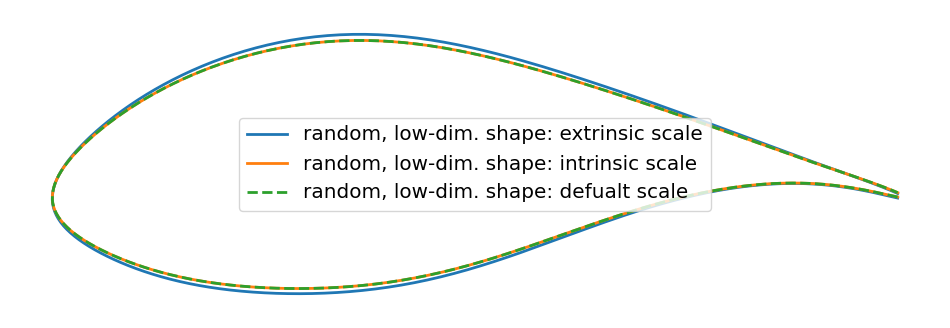

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(rnd_shape_avg[:,0], rnd_shape_avg[:,1], lw=2, label='random, low-dim. shape: extrinsic scale')
plt.plot(rnd_shape[:,0], rnd_shape[:,1], lw=2, label='random, low-dim. shape: intrinsic scale')
plt.plot(rnd_shape_defualt[:,0],rnd_shape_defualt[:,1],'--', lw=2, label='random, low-dim. shape: defualt scale')
plt.axis('off')
ax.axis('equal')
ax.legend(fontsize='x-large')

### Automated shape generation
We can use automated routine to generate as many non-intersecting r-dimensional shapes as desired by setting `n`: in this case `n=10` samples and we utilize the full-dimension expansion (`r=18`).

Note: "warnings" are issued by the automated routine when a shape intersects itself. A new random `coef` is subsequently drawn to replace the corresponding index until the the shape is non-intersecting. This is akin to a crude form of hit-and-run for sampling the rather complicated self-intersections constraint. Future versions of this repository may include more sophisticated approaches to random sampling.

In [5]:
rnd_shapes, rnd_Gr_shapes, rnd_coef = pga.generate_perturbed_shapes(n=10, n_modes=18)
print('\nRandom data:')
print(f'Random shapes shape: {rnd_shapes.shape}')
print(f'Random coord. shape: {rnd_coef.shape}')


Random data:
Random shapes shape: (10, 401, 2)
Random coord. shape: (10, 18)


Next, let's plot the first random shape in the set of 10 randomly sampled shapes generated by the automated routine. Additionally, we'll reduce the coordinate expansion of the full-dimensional shapes down to 2, 4, and 8, then overlay the low-dimensional expansions of the shape along consistently reduced coordinates (lower-dimensional planar sections of the Grassmanian). 

Notice that with increasing dimension, we can capture more undulation in the shape, and the 8-dimensional shape is nearly visually indistinguishable from the full 18-dimensional shape, while the 2- and 4-dimensional shapes are regularized to have reduced inflection. Visually inspecting the first random shape below, we can observe the regularization achieved with reduced dimensionality (similar to the results of the previous notebook: [Data-Driven Domain of Shapes](https://g2aero.readthedocs.io/en/latest/how_to_guides/files/0_Data-Driven_Domain.html#)). 

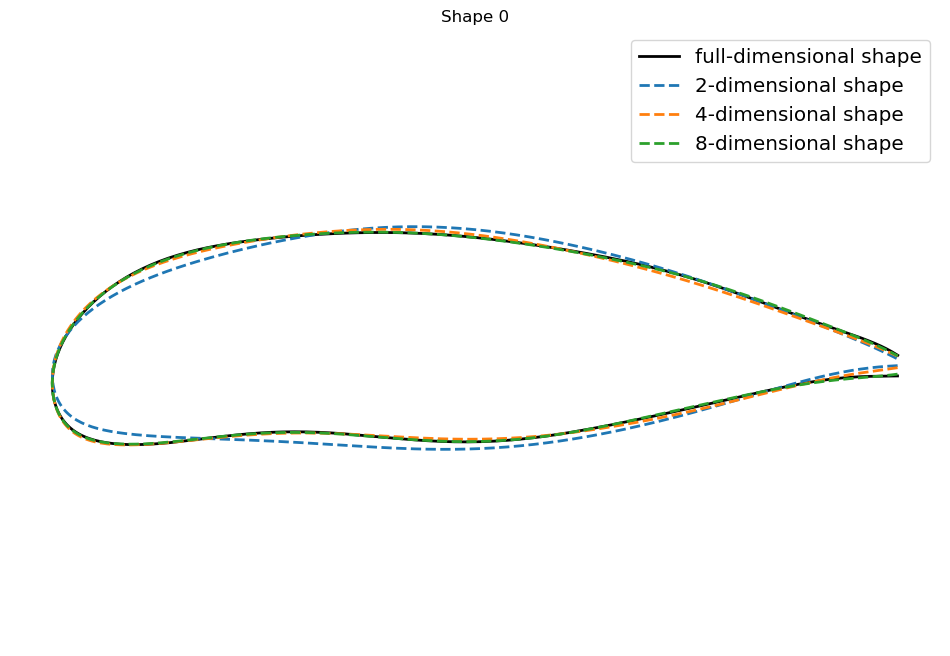

In [6]:
rnd_i = 0          # pick the first random index to closely inspect
dims = [2, 4, 8]
# plot the random shape with different scale
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.plot(rnd_shapes[rnd_i,:,0], rnd_shapes[rnd_i,:,1],'k', lw=2, label='full-dimensional shape')

for dim in dims:   # loop through low-dimension analogs
    shape_low = pga.PGA2shape(rnd_coef[rnd_i,:dim])
    plt.plot(shape_low[:,0], shape_low[:,1], '--', lw=2, label=f"{dim}-dimensional shape")
ax.set_title(f'Shape {rnd_i}')
plt.axis('off')
ax.axis('equal')
ax.legend(fontsize='x-large')

Let's also plot the full smattering of all 10 of our randomly generated shapes and compare them to consistent low-dimensional analogs (similar to above). Even with all 10 randomly generated shapes, we draw the same conclusions as above: reduced dimensionality helps regularize against undulation in shape. Note that the curves' colors for all 10 random shapes below are consistent with the legend in the example above.

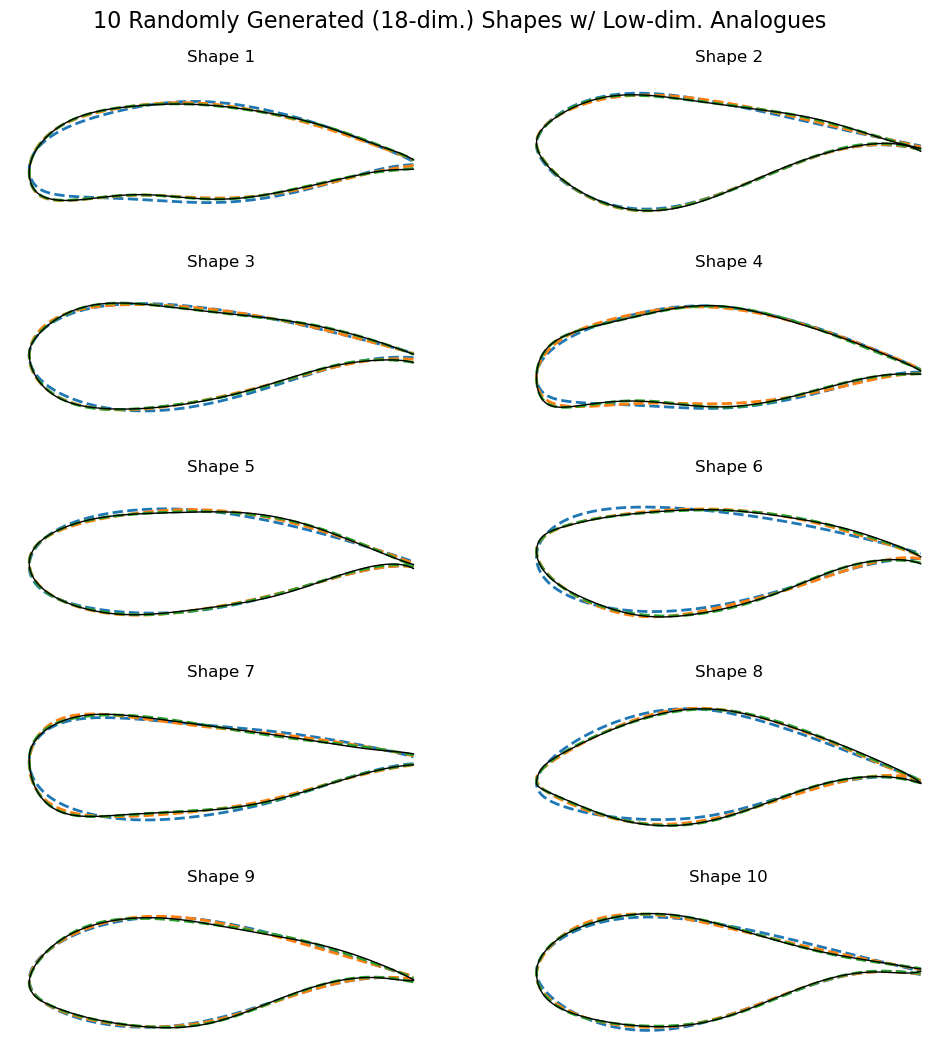

In [7]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.25, top=0.93)
plt.suptitle(f"{10} Randomly Generated ({18}-dim.) Shapes w/ Low-dim. Analogues", fontsize=16)

# loop through the length of shapes
for i, shape in enumerate(rnd_shapes):
    ax = plt.subplot(5, 2, i + 1)    # add a new subplot iteratively
    
    for dim in dims:   # loop through low-dimension analogs
        shape_low = pga.PGA2shape(rnd_coef[i,:dim])
        plt.plot(shape_low[:,0], shape_low[:,1], '--', lw=2, label=f"{dim}-dimensional")
    # plot the random shape
    plt.plot(shape[:,0], shape[:,1], 'k', lw=1, label="full-dimensional")    
    ax.set_title(f'Shape {i+1}')
    ax.set_xlabel("")
    ax.axis('off')
    ax.axis('equal')

## Consistency in perturbations

Lastly, let's emphasize the notion of consistency in perturbations. 

First, we take the two most distinct shapes based on pairwise distances between all 10 randomly generated shapes. 

In [8]:
# determine the most different shapes based on the pairwise Grassmannian distance
dist = np.zeros((10, 10))
for i in range(10):
    for j in range(i, 10):
        # compute unique elements of the pairwise distance matrix
        dist[i, j] = gr.distance(rnd_Gr_shapes[i], rnd_Gr_shapes[j])
# determine the largest pair of shapes
i_max = np.unravel_index(np.argmax(dist), dist.shape)
print(f'The dictance between shape {i_max[0]} and shape {i_max[1]} is largest')
shapes_max = [rnd_Gr_shapes[i_max[0]], rnd_Gr_shapes[i_max[1]]]

The dictance between shape 6 and shape 7 is largest


Then, we reuse our manually configured perturbation direction from above and utilize the Grassmannian parallel translation utility to perturb disparate shapes in a consistent way.

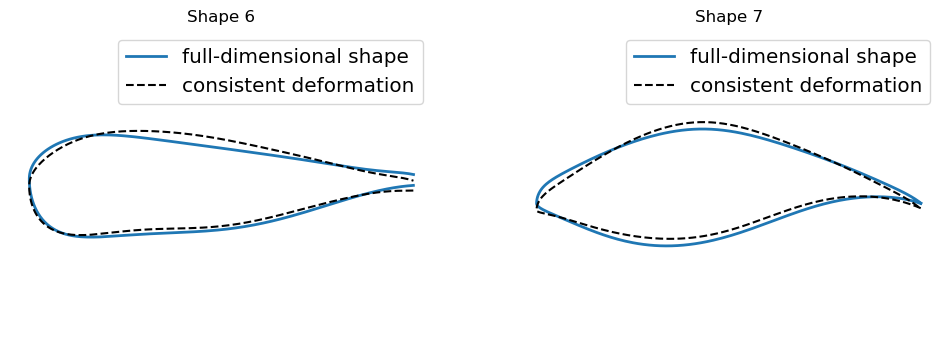

In [9]:
# take a random vector at the Karcher mean of arbitrary dimension
V0 = (rnd_t@pga.Vh[:r]).reshape(-1,2)
# now plot consistent perturbations between the disparate shapes
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, shape in enumerate(shapes_max):
    end_point_direction = gr.log(pga.karcher_mean, shape)
    # parallel translate the vector to the disparate shapes
    V = gr.parallel_translate(pga.karcher_mean, end_point_direction, V0)
    # perturb the shapes along the consistent directions at disparate tangent spaces
    P = gr.exp(1, shape, V)
    # rescale to an appropriate section of the fiber bundle
    new_shape = P @ pga.M_mean + pga.b_mean
    
    # plot results
    ax[i].plot(rnd_shapes[i_max[i],:,0], rnd_shapes[i_max[i],:,1], lw=2, label='full-dimensional shape')
    ax[i].plot(new_shape[:,0], new_shape[:,1],'k--',label='consistent deformation')
    ax[i].set_title(f'Shape {i_max[i]}')
    ax[i].axis('off')
    ax[i].axis('equal')
    ax[i].legend(fontsize='x-large')

Notice the visual consistency in the perturbations applied to the two disparate shapes. The perturbations undulate "inward" towards the shape centroid or "outward" away from the shape centroid at consistent landmark arc-length locations. For example, start at any point on the shapes and follow the blue curves around the shapes as though we are tracing the full-dimensional shapes on paper. Notice, as we trace, the black dashed curves deform the shapes consistently inward or outward as we move along the curves, even though that the base shapes are completely different (not comparable otherwise). Consequently, we can deform distinct shapes in a consistent way to regularize deformations along interpolations of planar shapes defining blades. We elaborate on this further for the purposes of blade design in [Blade Perturbations](https://g2aero.readthedocs.io/en/latest/how_to_guides/files/3_Blade_perturbation.html#).